<a href="https://colab.research.google.com/github/fclubb/EarthSurfaceProcesses/blob/master/Week3_FluvialIncision/Part3_SanGabrielMountains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Channel steepness analysis of the San Gabriel Mountains, California



*This lesson has been written Fiona Clubb at Durham University, based on an original notebook by Simon M. Mudd at the University of Edinburgh*

Now we've had a look at some channel profiles and the stream power incision model, we are going to try to extract some channel profiles from a real landscape and explore how channel steepness varies across the landscape. You should be able to modify this notebook for different areas for use in your independent project, if you like.

We are going to be using the San Gabriel Mountains, California, as an example. Channel steepness has been found to increase non-linearly with erosion rates in this landscape (DiBiase et al., 2010). It would be helpful if you had a look at this paper before doing the practical:


---

*DiBiase, R.A., Whipple, K.X., Heimsath, A.M. and Ouimet, W.B., 2010. Landscape form and millennial erosion rates in the San Gabriel Mountains, CA. Earth and Planetary Science Letters, 289(1-2), pp.134-144. https://doi.org/10.1016/j.epsl.2009.10.036*

---



We're going to use a python package called `lsdviztools` to download a digital elevation model (DEM) with a resolution of 30 m. This is from the Shuttle Radar Topography Mission (SRTM): this DEM is available pretty much globally, so it's very useful for this module and potentially for your dissertation project.

We also will do a little bit of topographic analysis using **lsdtopotools**. **lsdtopotools** is a software package for analysing topography developed at the University of Edinburgh, Durham University, and other institutions. 

## Get the right python packages

In this first cell we're going to install `lsdtopotools` and `lsdviztools`. 
**WARNING - the first time you do this, it might take up to 5 minutes. Just wait for it to finish and then you don't have to run it again for the rest of the practical (even if you need to restart the kernel).**



In [ ]:
!pip install lsdviztools &> /dev/null


First we download miniconda, which takes about 30 seconds.

In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.8.2-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT &> /dev/null
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX &> /dev/null


The next step is to set the conda channels, install mamba (because it installs lsdtopotools much faster than conda) and then finally lsdtopotools. This takes ~3.5 minutes.

In [ ]:
!conda config --add channels conda-forge &> /dev/null
!conda config --set channel_priority strict &> /dev/null
!conda install -c conda-forge -y mamba &> /dev/null
!mamba install -c conda-forge -y lsdtopotools &> /dev/null

In [18]:
#lsdtopotools
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw

#pandas
import pandas as pd
import geopandas as gpd

#colab
from google.colab import files

#general
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
%matplotlib inline

## Now grab some data

First, we need to grab some data. We use a tool in `lsdviztools.lsdbasemaptools` called the `ot_scraper` (`ot` is for opentopography.org).

You can tell this what sort of data you want (most people will use the SRTM 30 metre data) and you also tell it the lower left and the upper right corners, using latitude and longitude. You can get these from goole earth by right clicking on the map and selecting "what's here". In this example below, I will just get a small area near Sorbas. But you might expand your search area. 

In [4]:
# If you want to modify the DEM, change the bounding latitude and longitude. Change the `Dataset_prefix` if you want to change the name of the output DEM.
Dataset_prefix = "San_Gabriel"
SG_DEM = bmt.ot_scraper(source = "SRTM30",longitude_W = -118.257749, longitude_E = -117.488604, 
                            latitude_S = 34.143650, latitude_N =  34.404547,prefix = Dataset_prefix)
SG_DEM.print_parameters()
SG_DEM.download_pythonic()

The source is: SRTMGL1
The west longitude is: -118.257749
The east longitude is: -117.488604
The south latitude is: 34.404547
The north latitude is: 34.14365
The path is: ./
The prefix is: San_Gabriel
The resolution is: 30
I am going to download the following for you:
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=34.14365&north=34.404547&west=-118.257749&east=-117.488604&outputFormat=GTiff
This might take a little while, depending on the size of the file. 
The filename will be:
./San_Gabriel_SRTMGL1.tif
The path and file without path are:
./  San_Gabriel_SRTMGL1.tif
Finished downloading


('./San_Gabriel_SRTMGL1.tif', './', 'San_Gabriel_SRTMGL1.tif')

That just downloaded a .tif file, which you can find in the "Files" tab in Google Colab. If you like you can download it and look at in a GIS. 
You can also look at the raw data here in python using something called `rasterio`. 

But we will use some tools called **lsdtopotools** to look at the data. 

To do that, we need to convert the data into a format **lsdtopotools** can understand. 

The option below uses something called GDAL (short for Geospatial Data Abstraction Library). 
It has many tools for converting raster data formats and changing projections. It is also fast: it is much faster to convert or merge files using gdal than in, say, ArcMap. QGIS has the gdal tools built in. You can read more here: https://lsdtopotools.github.io/LSDTT_documentation/LSDTT_introduction_to_geospatial_data.html#translating-your-raster-into-something-that-can-be-used-by-lsdtopotoolbox

In the below line the main thing you would change is the zone: this is the UTM zone. You can look up your UTM zone here: http://www.dmap.co.uk/utmworld.htm

In [5]:
import subprocess

# Below is the resolution of your data in metres
res = "30"

# Change the below UTM zone to the correct zone for your dataset
pr = "+proj=utm +zone=10 +datum=WGS84"

# Dont change the stuff below this line
gd = "gdalwarp"
sr = "-t_srs"
of = "-of"
en = "ENVI"
ov = "-overwrite"
tr = "-tr"
r = "-r"
rm = "cubic"
infile = Dataset_prefix+"_SRTMGL1.tif"
outfile = Dataset_prefix+"_SRTMGL1_UTM.bil"

subprocess_list = [gd, sr, pr, of, en, ov, tr, res, res, r, rm, infile, outfile]

subprocess.run(subprocess_list)

# Below is the gdalwarp call that is not used but is here for future reference
#!gdalwarp -t_srs '+proj=utm +zone=30 +datum=WGS84' -of ENVI -overwrite Sorbas_SRTM30.tif Sorbas_SRTM30_UTM.bil

CompletedProcess(args=['gdalwarp', '-t_srs', '+proj=utm +zone=10 +datum=WGS84', '-of', 'ENVI', '-overwrite', '-tr', '30', '30', '-r', 'cubic', 'San_Gabriel_SRTMGL1.tif', 'San_Gabriel_SRTMGL1_UTM.bil'], returncode=0)

## Now we do some topographic analysis and look at the data

We will extract some topogaphic metrics using `lsdtopotools`, which we installed earlier in the notebook.

The `lsdtt_parameters` are the various parametes that you can use to run an analysis. We will discuss these later. For now, we will just follow this recipe. 

In [6]:
lsdtt_parameters = {"write_hillshade" : "true",  
                    "surface_fitting_radius" : "60",
                    "print_slope" : "true"}
r_prefix = Dataset_prefix+"_SRTMGL1_UTM"
w_prefix = Dataset_prefix+"_SRTMGL1_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()


The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: San_Gabriel_SRTMGL1_UTM
The write prefix is: San_Gabriel_SRTMGL1_UTM
The parameter dictionary is:
{'write_hillshade': 'true', 'surface_fitting_radius': '60', 'print_slope': 'true'}


In [7]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


That will take a little while to run (wait until there is a number in brackets beside the `In` to the right of the cell.)

It will spit out some files. If you want to see what files are in this directory after the cell has finished you can run the following cell:

In [8]:
!ls

Miniconda3-py37_4.8.2-Linux-x86_64.sh
sample_data
San_Gabriel_SRTMGL1.tif
San_Gabriel_SRTMGL1_UTM_AllBasins.bil
San_Gabriel_SRTMGL1_UTM_AllBasins.hdr
San_Gabriel_SRTMGL1_UTM_AllBasinsInfo.csv
San_Gabriel_SRTMGL1_UTM_Basins.cpg
San_Gabriel_SRTMGL1_UTM_Basins.dbf
San_Gabriel_SRTMGL1_UTM_Basins.prj
San_Gabriel_SRTMGL1_UTM_Basins.shp
San_Gabriel_SRTMGL1_UTM_Basins.shx
San_Gabriel_SRTMGL1_UTM.bil
San_Gabriel_SRTMGL1_UTM.bil.aux.xml
San_Gabriel_SRTMGL1_UTM_chi_data_map.csv
San_Gabriel_SRTMGL1_UTM.hdr
San_Gabriel_SRTMGL1_UTM_hs.bil
San_Gabriel_SRTMGL1_UTM_hs.hdr
San_Gabriel_SRTMGL1_UTM_ingestedParam.param
San_Gabriel_SRTMGL1_UTM_MChiSegmented.csv
San_Gabriel_SRTMGL1_UTM_SLOPE.bil
San_Gabriel_SRTMGL1_UTM_SLOPE.hdr
Test_01.driver


You will see that we have made some new rasters. We have made
* *San_Gabriel_SRTMGL1_UTM_hs*: a hillshade
* *San_Gabriel_SRTMGL1_UTM_SLOPE*: a slope raster




---


## Exercise 1

* Download the hillshade and the slope raster (each one is made of two files: one ending in `.bil` and one ending in `.hdr`. Open QGIS or ArcGIS and load the rasters (drag the `.bil` file into the window).

* Make a shaded slope map of the study area: to do this, load in both files and make sure the slope map is the top layer. Give the slope a transparency, say 50%, so you can see the hillshade through it.


---




## Get some channel profiles

Okay, we will now run a different analysis which will allow us to get channel profiles for a range of drainage basins in the region.

In [ ]:
lsdtt_parameters = {"print_basin_raster" : "true",
                    "print_chi_data_maps" : "true",
                    "minimum_basin_size_pixels" : "5000"}
r_prefix = Dataset_prefix+"_SRTMGL1_UTM"
w_prefix = Dataset_prefix+"_SRTMGL1_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: San_Gabriel_SRTMGL1_UTM
The write prefix is: San_Gabriel_SRTMGL1_UTM
The parameter dictionary is:
{'print_basin_raster': 'true', 'print_chi_data_maps': 'true', 'minimum_basin_size_pixels': '5000'}


In [ ]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


Now let's run this code which makes a shapefile from the basins raster that we just calculated:

In [23]:
# TO ADD HERE - GET SHAPEFILE OF THE BASINS FROM THE RASTER.
gio.PolygoniseRaster('./', Dataset_prefix+'_SRTMGL1_UTM_AllBasins.bil', OutputShapefile=Dataset_prefix+'_SRTMGL1_UTM_Basins.shp')

Let me grab the coordinate reference system.
EPSG:32610
Whoops. Found a repeated ID. Getting rid of the smaller one.
Found a repeated ID. Keeping the one with area of 7504200.0
Whoops. Found a repeated ID. Getting rid of the smaller one.
Keeping the initial ID.
Whoops. Found a repeated ID. Getting rid of the smaller one.
Found a repeated ID. Keeping the one with area of 254759400.0
Whoops. Found a repeated ID. Getting rid of the smaller one.
Found a repeated ID. Keeping the one with area of 5278500.0
Whoops. Found a repeated ID. Getting rid of the smaller one.
Keeping the initial ID.
Whoops. Found a repeated ID. Getting rid of the smaller one.
Keeping the initial ID.
I need to convert the crs to wkt format so it is resistant to stupid proj errors.
ID is: 44.0
ID is: 71.0
ID is: 54.0
ID is: 58.0
ID is: 239.0
ID is: 22.0
ID is: 62.0
ID is: 38.0
ID is: 246.0
ID is: 339.0
ID is: 68.0
ID is: 123.0
ID is: 101.0
ID is: 436.0
ID is: 174.0
ID is: 480.0
ID is: 774.0
ID is: 898.0
ID is: 1128.0
ID

{22.0: <shapely.geometry.polygon.Polygon at 0x7f69c31fa490>,
 38.0: <shapely.geometry.polygon.Polygon at 0x7f69c31db210>,
 44.0: <shapely.geometry.polygon.Polygon at 0x7f69c35a33d0>,
 54.0: <shapely.geometry.polygon.Polygon at 0x7f69c31edd90>,
 58.0: <shapely.geometry.polygon.Polygon at 0x7f6a008958d0>,
 62.0: <shapely.geometry.polygon.Polygon at 0x7f69c31dbf90>,
 68.0: <shapely.geometry.polygon.Polygon at 0x7f69c35b79d0>,
 71.0: <shapely.geometry.polygon.Polygon at 0x7f6a00895f10>,
 101.0: <shapely.geometry.polygon.Polygon at 0x7f69c31faad0>,
 123.0: <shapely.geometry.polygon.Polygon at 0x7f69c31fafd0>,
 174.0: <shapely.geometry.polygon.Polygon at 0x7f69c35ac810>,
 219.0: <shapely.geometry.polygon.Polygon at 0x7f69c307c5d0>,
 239.0: <shapely.geometry.polygon.Polygon at 0x7f69c35ac390>,
 246.0: <shapely.geometry.polygon.Polygon at 0x7f69c31dbf10>,
 339.0: <shapely.geometry.polygon.Polygon at 0x7f69c3621b50>,
 436.0: <shapely.geometry.polygon.Polygon at 0x7f69c35b7150>,
 480.0: <shapely

If you look at the files that we have created, you'll see that a number of new files now exist: The new files we've created are:


*   *San_Gabriel_SRTMGL1_UTM_AllBasins.bil* and *.hdr*: a raster showing you the basins that were extracted
*   *San_Gabriel_SRTMGL1_UTM_AllBasins.shp*: a shapefile of the basins
*   **San_Gabriel_SRTMGL1_UTM_chi_data_map.csv*: a CSV file with the information about the channel profiles. We will talk more about 'chi' profiles in a later practical. A CSV file can be loaded into Excel (although it will be really big, so I wouldn't recommend it). We can also load it in Python using a package called `geopandas`, which we'll do below.



You might have noticed that the basins shapefile has lots of different files that you need to download. You can run this code block to download them automatically (NOTE - WILL ONLY WORK WITH CHROME)

In [25]:
files.download(Dataset_prefix+'_SRTMGL1_UTM_Basins.shp')
files.download(Dataset_prefix+'_SRTMGL1_UTM_Basins.dbf')
files.download(Dataset_prefix+'_SRTMGL1_UTM_Basins.prj')
files.download(Dataset_prefix+'_SRTMGL1_UTM_Basins.shx')
files.download(Dataset_prefix+'_SRTMGL1_UTM_Basins.cpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---


## Exercise 2

Download the above files and load them into QGIS. You should be able to see the basins that we have extracted using the code. 


---



## Choose a basin for analysis
Now we are going to read in the channel data for a basin of your choice using geopandas. 

After this finishes running it will produce a csv file. 

These csv files can be read here, in the python environment. But they can also be loaded into a GIS by importing text data. You can make a file that is immediatly readable using a GIS by adding the option `convert_csv_to_geojson` to the parameters, so the command two cells up would become:

    lsdtt_parameters = {"print_basin_raster" : "true",
                        "print_chi_data_maps" : "true",
                        "convert_csv_to_geojson" : "true",
                        "minimum_basin_size_pixels" : "5000"}
                        
The disadvantage of this is that geojson files are much larger than csv. And you really only use these files with a GIS: if you use python you will be using the csv file. 

Okay, the cells below load a csv file using first `pandas` and then converts it into `geopandas` (which is `pandas` with georeferencing). This allows us to make what's called a `dataframe` (a data table, similar to Excel), in Python:

In [26]:
chi_data_map_name = Dataset_prefix+"_SRTMGL1_UTM_chi_data_map.csv"
df = pd.read_csv(chi_data_map_name)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = "EPSG:4326" 
print(gdf.head())

    latitude   longitude  ...  basin_key                     geometry
0  34.358962 -117.588918  ...          0  POINT (-117.58892 34.35896)
1  34.359246 -117.589226  ...          0  POINT (-117.58923 34.35925)
2  34.359515 -117.589209  ...          0  POINT (-117.58921 34.35952)
3  34.359799 -117.589516  ...          0  POINT (-117.58952 34.35980)
4  34.360083 -117.589823  ...          0  POINT (-117.58982 34.36008)

[5 rows x 9 columns]


We can use the following command to see what columns we have in our data table:

In [27]:
gdf.columns

Index(['latitude', 'longitude', 'chi', 'elevation', 'flow_distance',
       'drainage_area', 'source_key', 'basin_key', 'geometry'],
      dtype='object')

Let's use this dataframe to plot a river profile! You should have seen from looking at the basins in QGIS that we have lots of different basins. If you look at the raster in QGIS, you can see that they are assigned a number which is a bit random. To make it more logical, each basin is also assigned a "basin_key" which starts at 0 and goes up. You can see the basin key information in the file `San_Gabriel_SRTMGL1_UTM_AllBasinsInfo.csv`:

In [28]:
basins_info = pd.read_csv(Dataset_prefix+'_SRTMGL1_UTM_AllBasinsInfo.csv')
basins_info

,latitude,longitude,outlet_latitude,outlet_longitude,outlet_junction,basin_key
0,34.374968,-117.590492,34.398069,-117.581507,22,0
1,34.368995,-117.638763,34.392714,-117.606943,38,1
2,34.386846,-117.645442,34.396427,-117.636032,44,2
3,34.385881,-117.710018,34.395889,-117.716556,54,3
4,34.387278,-118.012663,34.401456,-118.009212,58,4
5,34.377166,-117.777358,34.391946,-117.788169,62,5
6,34.371340,-117.973207,34.397645,-117.969023,68,6
7,34.392961,-117.888806,34.400884,-117.890930,71,7
8,34.345110,-117.538684,34.316231,-117.491081,101,8
9,34.365830,-117.905444,34.385332,-117.939129,123,9


Let's choose a basin that we want to make a plot of using the basin key. If you want to change the basin, just change the basin key to another one from the table above.

In [29]:
# set the basin key that you want to plot here
basin_key = 10

Then run the below cell to make a plot of the river profiles in that basin. We will make two plots: the first one is the entire river network, and the second one is the main stem only:

<Figure size 720x720 with 0 Axes>

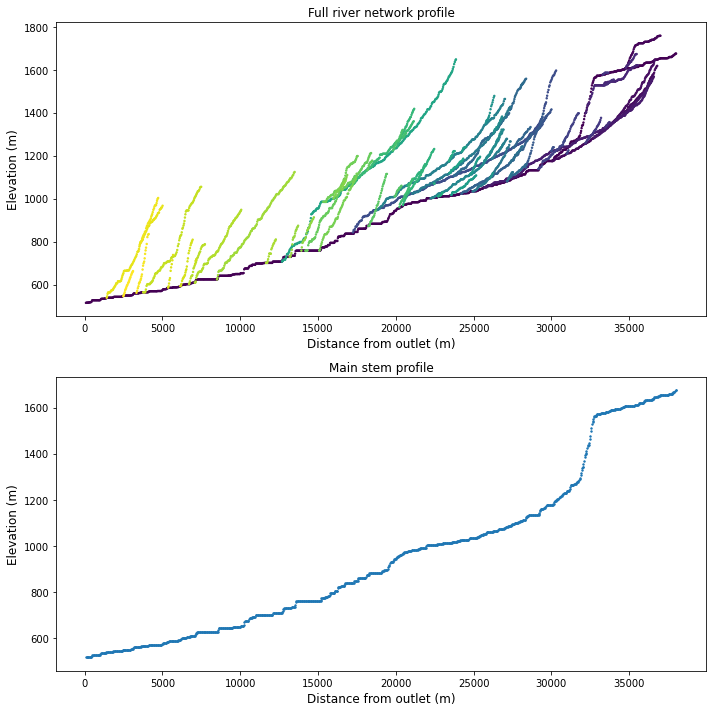

In [16]:
# then do the plotting
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == basin_key)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(gdf_b1['flow_distance'], gdf_b1['elevation'],c=gdf_b1['source_key'], s = 2)
ax2.scatter(gdf_b2['flow_distance'], gdf_b2['elevation'],s = 2)


ax1.set_xlabel("Distance from outlet (m)", fontsize=12)
ax1.set_ylabel("Elevation (m)", fontsize=12)
ax1.set_title('Full river network profile')

ax2.set_xlabel("Distance from outlet (m)", fontsize=12)
ax2.set_ylabel("Elevation (m)", fontsize=12)
ax2.set_title('Main stem profile')

plt.tight_layout()



---


## Exercise 3

Choose one of the basins from the area and make a nice plot of the river profile. What features can you see in the profile? Are there any knickpoints (steepened reaches of the profile?)

Write a short figure caption that describes the figure you have made, and explains the key of the river profile with reference to the slope map that you produced in Exercise 1.


---




## Getting the full channel profile with steepness information

In lesson 2, we are going to work with a file that has the extension `_MChiSegmented.csv`. 
To generate this file, you need to run the following command.

**Warning**: This is quite computationally expensive so if you have a big area it will take a while for this routine to finish. 

In [12]:
command_line_tool = "lsdtt-chi-mapping"
lsdtt_parameters = {"print_segmented_M_chi_map_to_csv" : "true", 
                    "print_basin_raster" : "true",
                    "convert_csv_to_geojson" : "true"}

r_prefix = Dataset_prefix+"_SRTMGL1_UTM"
w_prefix = Dataset_prefix+"_SRTMGL1_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool,read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-chi-mapping
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: San_Gabriel_SRTMGL1_UTM
The write prefix is: San_Gabriel_SRTMGL1_UTM
The parameter dictionary is:
{'print_segmented_M_chi_map_to_csv': 'true', 'print_basin_raster': 'true', 'convert_csv_to_geojson': 'true'}
Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


We can use the `!ls` command to see if the file is there (the `!` tells the notebook to access the underlying linux operating system, and `ls` is a linux command that lists (`ls` is short for list) the contents of the current directory).

In [32]:
!ls

Miniconda3-py37_4.8.2-Linux-x86_64.sh
sample_data
San_Gabriel_SRTMGL1.tif
San_Gabriel_SRTMGL1_UTM_AllBasins.bil
San_Gabriel_SRTMGL1_UTM_AllBasins.hdr
San_Gabriel_SRTMGL1_UTM_AllBasinsInfo.csv
San_Gabriel_SRTMGL1_UTM_Basins.cpg
San_Gabriel_SRTMGL1_UTM_Basins.dbf
San_Gabriel_SRTMGL1_UTM_Basins.prj
San_Gabriel_SRTMGL1_UTM_Basins.shp
San_Gabriel_SRTMGL1_UTM_Basins.shx
San_Gabriel_SRTMGL1_UTM.bil
San_Gabriel_SRTMGL1_UTM.bil.aux.xml
San_Gabriel_SRTMGL1_UTM_chi_data_map.csv
San_Gabriel_SRTMGL1_UTM.hdr
San_Gabriel_SRTMGL1_UTM_hs.bil
San_Gabriel_SRTMGL1_UTM_hs.hdr
San_Gabriel_SRTMGL1_UTM_ingestedParam.param
San_Gabriel_SRTMGL1_UTM_MChiSegmented.csv
San_Gabriel_SRTMGL1_UTM_SLOPE.bil
San_Gabriel_SRTMGL1_UTM_SLOPE.hdr
Test_01.driver


Okay, the data is there, it is called `San_Gabriel_SRTMGL1_UTM_MChiSegmented.csv`. Lets load it with `geopandas`.

In [10]:
segmented_data_map_name = w_prefix+"_MChiSegmented.csv"
df = pd.read_csv(segmented_data_map_name)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = "EPSG:4326" 
print(gdf.head())

     node  row  ...  segmented_elevation                     geometry
0  294816  185  ...               1731.8  POINT (-117.58892 34.35896)
1  292448  184  ...               1726.9  POINT (-117.58923 34.35925)
2  290081  183  ...               1724.1  POINT (-117.58921 34.35952)
3  287713  182  ...               1719.8  POINT (-117.58952 34.35980)
4  285345  181  ...               1715.0  POINT (-117.58982 34.36008)

[5 rows x 15 columns]


Now let's look at the columns that are in our data table from this new analysis:

In [11]:
gdf.columns

Index(['node', 'row', 'col', 'latitude', 'longitude', 'chi', 'elevation',
       'flow_distance', 'drainage_area', 'm_chi', 'b_chi', 'source_key',
       'basin_key', 'segmented_elevation', 'geometry'],
      dtype='object')

You can see that this dataset has a lot more information about the channel network! We have one column in particular, the `m_chi` column, which is very useful. This tells us **the steepness of the channel network at each point.** This is based on the $\chi$, or chi, analysis approach, which we covered in the lecture. You can think of this as being equivalent to $K_{sn}$ as calculated from slope-area plots.

Let's make our long profile plot again, but colour the channels by their steepness using the `m_chi` column. You can set the colour map that you want to use as the colours by changing the `cmap` parameter in the cell below. You can find a list of available colourmaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [13]:
# set the basin key that you want to plot here
basin_key = 10

In [23]:
# choose the colourmap that you want to use.
cmap = cm.viridis

<Figure size 720x720 with 0 Axes>

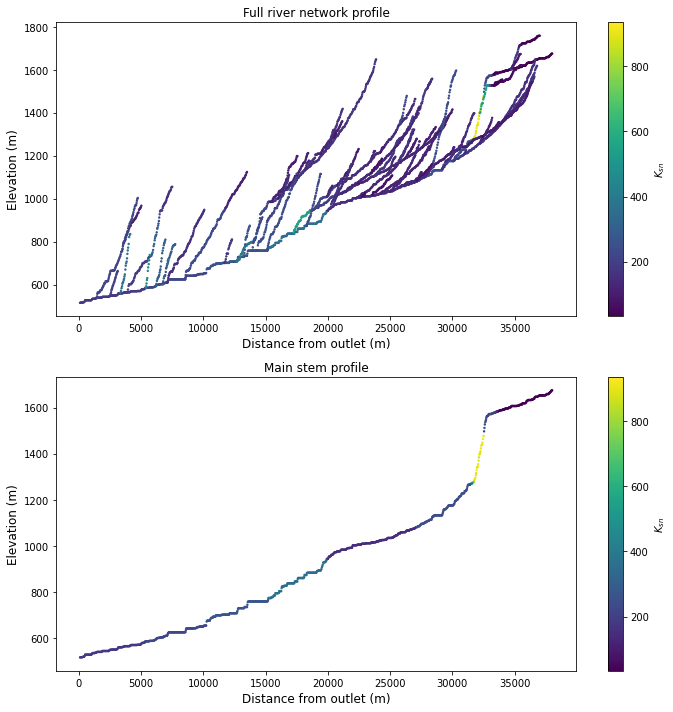

In [30]:
# then do the plotting
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == basin_key)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
c1 = ax1.scatter(gdf_b1['flow_distance'], gdf_b1['elevation'],c=gdf_b1['m_chi'], s = 2, cmap=cmap)
c2 = ax2.scatter(gdf_b2['flow_distance'], gdf_b2['elevation'],c=gdf_b2['m_chi'], s = 2, cmap=cmap)

ax1.set_xlabel("Distance from outlet (m)", fontsize=12)
ax1.set_ylabel("Elevation (m)", fontsize=12)
ax1.set_title('Full river network profile')

ax2.set_xlabel("Distance from outlet (m)", fontsize=12)
ax2.set_ylabel("Elevation (m)", fontsize=12)
ax2.set_title('Main stem profile')

# add colourbars to each axis
plt.colorbar(c1, cmap=cmap, ax=ax1, label = '$K_{sn}$')
plt.colorbar(c2, cmap=cmap, ax=ax2, label = '$K_{sn}$')

plt.tight_layout()